In [1]:
import numpy as np
import math
from fractions import Fraction
from tqdm import tqdm
import multiprocessing as mp
from haversine import haversine, Unit
import matplotlib.pyplot as plt
import os
import random
import matplotlib
from scipy.sparse import lil_matrix, csr_matrix
import gc
import time
from multiprocessing import shared_memory

In [2]:
# Astronomy-related constants

TE = 24 * 3600  # One Earth sidereal day in seconds

RE = 6371e3  # Mean radius of Earth in meters

u = 3.986e14  # Standard gravitational parameter (μ = GM) in m^3/s^2

K = RE / pow(u, 1/3) * pow(2 * np.pi, 2/3)  

eps = 25 * np.pi / 180  # Maximum elevation angle for ground access, in radians (25°)

In [13]:
def satellite_period(h):
    # Compute satellite orbital period (h in meters)
    a = RE + h
    T = float(2 * np.pi * (a**3 / u)**0.5)
    return T

def coverage_eta(T):
    # Compute satellite coverage angle (in radians)
    eta = math.acos(K * math.cos(eps) / T**(2/3)) - eps 
    return eta

def approximate_ratio(a, b, precision=1e-3):
    # Find approximate integer ratio a:b within precision
    if b == 0:
        raise ValueError("Denominator cannot be zero")
    ratio = Fraction(a, b).limit_denominator(int(1/precision))
    return ratio.numerator, ratio.denominator

def alpha_gamma_to_lambda_phi(alpha, gamma, inc):
    # Convert (alpha, gamma) to (longitude, latitude) given inclination
    phi = math.asin(math.sin(inc) * math.sin(gamma))
    temp = math.atan2(math.cos(inc) * math.sin(gamma), math.cos(gamma))
    lamb = (temp + alpha) % (2 * math.pi)
    if lamb > math.pi:
        lamb -= 2 * math.pi
    return lamb, phi

def is_cover(l_sat, p_sat, l_cell, p_cell, eta):
    # Check if satellite at (l_sat, p_sat) covers cell at (l_cell, p_cell)
    if (p_sat - 2*eta) < -np.pi/2 or (p_sat + 2*eta) > np.pi/2 or (l_sat - 2*eta) < -np.pi or (l_sat + 2*eta) > np.pi:
        d = haversine((np.degrees(p_sat), np.degrees(l_sat)), (np.degrees(p_cell), np.degrees(l_cell)), unit=Unit.METERS)
        return d <= eta * RE
    if (p_sat - 2*eta) <= p_cell <= (p_sat + 2*eta) and (l_sat - 2*eta) <= l_cell <= (l_sat + 2*eta):
        d = haversine((np.degrees(p_sat), np.degrees(l_sat)), (np.degrees(p_cell), np.degrees(l_cell)), unit=Unit.METERS)
        return d <= eta * RE
    return False

def recover_fulltime(data):
    # Reconstruct full-time coverage from partial satellite slots
    random_numbers, cover, n_length = data
    selected_cover = lil_matrix((1, n_length), dtype=np.float64)
    sat_location = []
    for t in range(time_split):
        for num in random_numbers:
            num = (num + t) % int(time_split)
            sat_location.append([cover[num][1], cover[num][2]])
            for idx, users in cover[num][0]:
                selected_cover[0, t * len(demand_list) + idx] += users
    return [selected_cover.tocsr(), sat_location]

def generate_baseset(args):
    # Compute full coverage for one satellite configuration
    file, random_numbers, sat_num = args
    file_param = file.split("/")[1].split("_")
    h = float(file_param[0])
    beta = float(file_param[1])
    alpha0 = float(file_param[2].split(".npy")[0])
    cover = cal_supply_all_cell(h, beta, alpha0)
    fulltime_cover = recover_fulltime([random_numbers, cover, n_length])
    return fulltime_cover
def cal_supply_all_cell(h, beta, a0):
    """
    Compute all ground coverage slots for a single stable satellite track.

    Args:
        h: Satellite altitude (km)
        beta: Inclination (rad)
        a0: Ascending node longitude (rad)

    Returns:
        total_supply: list of [covered_cells, lon, lat] for each slot
    """
    T = satellite_period(h * 1e3)
    p, q = approximate_ratio(int(T), TE, precision=1e-3)
    eta = coverage_eta(T)
    step = 2 * eta
    inc = beta

    total_supply = []
    slot_num = int(2 * np.pi * q / step)

    for i in range(slot_num):
        t = step * i / (2 * np.pi / T)
        a_sat = (a0 - (2 * np.pi / TE) * t) % (2 * np.pi)
        b_sat = (step * i) % (2 * np.pi)
        l_sat, p_sat = alpha_gamma_to_lambda_phi(a_sat, b_sat, inc)

        r_set = []
        for idx, demand in enumerate(demand_list):
            l_cell = demand['lat_lon'][1]
            p_cell = demand['lat_lon'][0]
            if is_cover(l_sat, p_sat, l_cell, p_cell, eta):
                S = S_set[idx]
                r_set.append([idx, S, demand['density']])

        if r_set:
            S_sum = np.sum([item[1] for item in r_set])
            factor = user_per_sat / S_sum
            r_set = [[item[0], item[1] * factor] for item in r_set]
            total_supply.append([r_set, l_sat, p_sat])

    return np.asarray(total_supply, dtype="object")
def compute_dot(args, show=False):
    # Compute dot product between residual R and satellite coverage
    R, cid = args
    global all_cover
    fulltime_cover = all_cover[cid][2][0]
    dot = fulltime_cover @ R
    return [dot[0], cid]

def update_residual(R, cid):
    # Subtract satellite supply (one config) from residual demand
    global all_cover
    R[all_cover[cid][0].indices] -= all_cover[cid][0].data
    R = np.maximum(R, 0)  # Ensure non-negative
    return R

def update_residual_diurnal(R, cid):
    # Subtract from residual for diurnal supply
    global all_cover_diurnal
    R[all_cover_diurnal[cid][0].indices] -= all_cover_diurnal[cid][0].data
    R = np.maximum(R, 0)
    return R

def find_max_in_chunk(chunk):
    # Find max value and its corresponding index in a chunk
    chunk = np.array(chunk)
    max_value = np.max(chunk[:, 0])
    local_index = np.argmax(chunk[:, 0])
    max_index = chunk[local_index][1]
    return [max_value, int(max_index)]


In [4]:
sat_height = 573

# Load demand and convert coordinates to radians
demand_list = np.load("../../Dataset/Demand/starlink_supply_2025_01_01_99449.npy", allow_pickle=True)
for demand in demand_list:
    demand['lat_lon'][0] = np.radians(demand['lat_lon'][0])
    demand['lat_lon'][1] = np.radians(demand['lat_lon'][1])

# Mask out cells not affected by diurnal variation
change_cell = np.load("data/cloudflare_over_time_0708.npy", allow_pickle=True).item()
for idx, demand in enumerate(demand_list):
    if idx not in change_cell:
        demand['density'] = 0

cell_size = 4  # degrees
user_per_sat = 960
time_split = 308
print(time_split)

# Compute area for each demand cell
S_set = []
for demand in demand_list:
    p_cell = demand['lat_lon'][0]  # latitude in radians
    h = RE * np.radians(cell_size)  # vertical height of cell
    L1 = RE * np.sin(np.pi / 2 - abs(p_cell)) * np.radians(cell_size)
    tmp = abs(p_cell - np.radians(cell_size))
    L2 = RE * np.sin(np.pi / 2 - min(tmp, np.pi / 2)) * np.radians(cell_size)
    if tmp > np.pi / 2:  # south polar cap
        h = RE * abs(p_cell + np.pi / 2)
    S = 0.5 * h * (L1 + L2)
    S_set.append(S)
    
selected_params=np.load("data/TinyLEO_for_starlink_100.npy",allow_pickle=True)
print(len(selected_params))
files=[]
sat_nums=0
base_cover_path="./"
for s_tmp in selected_params:
    param_tmp,slots,satmaps,sat_num=s_tmp
    tmp=base_cover_path+str(int(param_tmp[0]))+"_"+str(param_tmp[1])+"_"+str(param_tmp[2])+".npy"
    files.append([tmp,slots,sat_num])
    sat_nums+=sat_num
all_cover=[]
n_length=len(demand_list)*time_split

with mp.Pool(processes=100) as pool:
    all_cover = list(tqdm(pool.imap(generate_baseset, files), total=len(files), mininterval=10,maxinterval=20))
    pool.close()  # Prevents any more tasks from being submitted to the pool
    pool.join()  # Wait for the worker processes to exit

308


In [19]:
# Flatten time-expanded demand vector
tmp_R = [demand['density'] for demand in demand_list]
ttmpR = tmp_R * time_split
R_2 = np.array(ttmpR).reshape(-1).copy()
R_sum_2 = np.sum(R_2)
print("Initial residual:", R_sum_2)
del ttmpR, tmp_R

# Iteratively subtract coverage and track residual change
process = []
for idx in range(len(all_cover)):
    R_2 = update_residual(R_2, idx)
    process.append([1, R_sum_2 - np.sum(R_2)])
    R_sum_2 = np.sum(R_2)
    print("Residual:", R_sum_2)

# Final residual stats
print(f"Remaining non-zero entries = {np.count_nonzero(R_2)}, max = {np.max(R_2)}, mean = {np.mean(R_2)}")


Initial residual: 6839597.16574378
Residual: 6828560.83100235
Residual: 6817524.496260921
Residual: 6806488.161519492
Residual: 6795451.826778061
Residual: 6784415.492036632
Residual: 6773379.1572952
Residual: 6762342.822553769
Residual: 6751306.487812338
Residual: 6740270.153070912
Residual: 6729233.818329485
Residual: 6718197.483588056
Residual: 6707161.148846628
Residual: 6696124.814105196
Residual: 6685088.479363764
Residual: 6674052.144622338
Residual: 6663016.2505272105
Residual: 6651979.915785785
Residual: 6640943.5810443545
Residual: 6629907.246302927
Residual: 6618870.911561497
Residual: 6607834.576820071
Residual: 6596798.242078637
Residual: 6585761.907337203
Residual: 6574725.572595776
Residual: 6563689.2378543485
Residual: 6552652.90311292
Residual: 6541617.0090177925
Residual: 6530682.6280470155
Residual: 6519748.247076237
Residual: 6508906.698711565
Residual: 6497885.42218539
Residual: 6486864.145659218
Residual: 6475939.7014818415
Residual: 6465015.257304461
Residual: 64

In [20]:
print(f"Remaining nonzero entries = {np.count_nonzero(R_2)}, Max = {np.max(R_2):.2f}, Mean = {np.mean(R_2):.2f}")

Remaining nonzero entries = 16, Max = 0.79, Mean = 0.00


# diurnal 

In [9]:
selected_params=np.load("data/TinyLEO_for_diurnal_pattern.npy",allow_pickle=True)
print(len(selected_params))
files=[]
sat_nums=0
for s_tmp in selected_params:
    param_tmp,slots,satmaps,sat_num=s_tmp
    tmp=base_cover_path+str(int(param_tmp[0]))+"_"+str(param_tmp[1])+"_"+str(param_tmp[2])+".npy"
    files.append([tmp,slots,sat_num])
    sat_nums+=sat_num
print(files[0])
print(sat_nums)
n_length=len(demand_list)*time_split
with mp.Pool(processes=100) as pool:
    all_cover_diurnal = list(tqdm(pool.imap(generate_baseset, files), total=len(files), mininterval=10,maxinterval=20))
    pool.close()  # Prevents any more tasks from being submitted to the pool
    pool.join()  # Wait for the worker processes to exit

1125
['/573_0.8377580409572782_4.956735075663896.npy', [17], 1]
1125


In [22]:
h=sat_height
T=satellite_period(h*1e3)
print(sat_height,T)
p,q=approximate_ratio(int(T), TE,precision=1e-3)
eta=coverage_eta(T)
step=2*eta
time_split=int(2*np.pi*q/step)
time_step=(T/(2*np.pi))*step
print(time_split)
change_cell=np.load("data/cloudflare_over_time_0708.npy",allow_pickle=True).item()
total_R=[]
for i in range(time_split):
    tmp_time=i*time_step
    time_index=round(tmp_time/60)//15*15
    tmp_R=[demand['density'] for demand in demand_list]
    for cid,values in change_cell.items():
        tmp_R[cid]=tmp_R[cid]*values[time_index]
    total_R.extend(tmp_R)
print(len(total_R)/len(tmp_R))
R_diurnal=np.array(total_R).reshape(-1)
standard_R_diurnal=sum(R_diurnal)
print(sum(R_diurnal))
print(standard_R_diurnal)
del total_R,tmp_R
# Copy the initial demand (with diurnal pattern)
R_2 = R_diurnal.copy()
R_sum_2 = np.sum(R_2)
print("Initial residual:", R_sum_2)

process_diurnal = []

# Iteratively subtract supply from each coverage set
for idx in range(len(all_cover_diurnal)):
    R_2 = update_residual_diurnal(R_2, idx)
    process_diurnal.append([1, R_sum_2 - np.sum(R_2)])
    R_sum_2 = np.sum(R_2)
    print(Residual:", R_sum_2)

573 5758.71770092658
308
308.0
3983267.411311159
3983267.411311159
Initial residual: 3983267.4113111896
Residual: 3973426.597634254
Residual: 3963504.241509808
Residual: 3953762.965625098
Residual: 3944045.7789604045
Residual: 3934400.8674345086
Residual: 3924705.149503937
Residual: 3914850.097342737
Residual: 3905204.7554150275
Residual: 3895300.6985037527
Residual: 3885532.292903557
Residual: 3875851.400357515
Residual: 3865955.237556633
Residual: 3856136.807775715
Residual: 3846443.446579948
Residual: 3836701.5646501887
Residual: 3826851.5976002733
Residual: 3817051.2495523696
Residual: 3807242.8950743624
Residual: 3797536.349531173
Residual: 3787761.035828742
Residual: 3778304.093058304
Residual: 3768708.1536302655
Residual: 3759249.763015232
Residual: 3749475.8452844108
Residual: 3740006.794501094
Residual: 3730292.314286985
Residual: 3720837.4616205716
Residual: 3711100.9350431818
Residual: 3701395.441105244
Residual: 3691741.370643789
Residual: 3682138.6390502853
Residual: 36729

In [23]:
# Final residual statistics
print(f"Non-zero residuals = {np.count_nonzero(R_2)}, max = {np.max(R_2)}, mean = {np.mean(R_2)}")

Non-zero residuals = 10, max = 0.6990630285547169, mean = 2.9839482829599644e-06


# 可视化

Static demand
99 : 1276
99.9 : 1420
99.99 : 1462
Diurnal pattern:
99 : 943
99.9 : 1047
99.99 : 1091


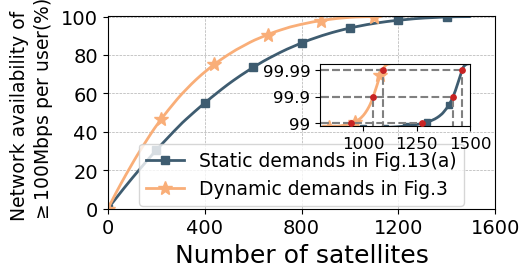

In [24]:
plt.rcParams['pdf.fonttype'] = 42
fig=plt.figure(figsize=(5,2.5))
colors=['#3E5C70','#F9AE78','#E47158']
plt_data=[0]
r_sum=sum([demand['density'] for demand in demand_list])*time_split
for item in process:
    for _ in range(item[0]):
        v=item[1]/item[0]/r_sum*100+plt_data[-1]
        plt_data.append(v)
plt.plot(plt_data,lw=2,color=colors[0],label="Static demands in Fig.13(a)",marker='s',markevery=200,markersize=6)

plt_data_diurnal=[0]
r_sum_diurnal=sum(R_diurnal)
for item in process_diurnal:
    for _ in range(item[0]):
        v=item[1]/item[0]/r_sum_diurnal*100+plt_data_diurnal[-1]
        plt_data_diurnal.append(v)
plt.plot(plt_data_diurnal,lw=2,color=colors[1],label="Dynamic demands in Fig.3",marker='*',markevery=220,markersize=10)

plt.legend(fontsize=13.5,loc="lower center",bbox_to_anchor=(0.5,-0.035))
plt.grid(True, linestyle="--", linewidth=0.5)
plt.xlim(0,1500)
plt.ylim(0,100.2)
plt.xticks([0,400,800,1200,1600],fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Network availability of \n $\geq$100Mbps per user(%)",fontsize=13.5)
plt.xlabel("Number of satellites",fontsize=18)

left,bottom,width,height = 0.55,0.44,0.3,0.25
ax2 = fig.add_axes([left,bottom,width,height])
trans_base=100.1
ax2.plot([1/(trans_base-item) for item in plt_data],color=colors[0],lw=2,marker='s',markevery=100,markersize=4)
ax2.plot([1/(trans_base-item) for item in plt_data_diurnal],color=colors[1],lw=2,marker='*',markevery=120,markersize=10)
# plt.yscale("log")
plt.xlim(800,1500)
plt.yticks([1/(trans_base-99),1/(trans_base-99.9),1/(trans_base-99.99)],[99,99.9,99.99],fontsize=12)
plt.ylim(1/(trans_base-98),1/(trans_base-100))
plt.xticks(fontsize=12)
print("Static demand")
for target in [99,99.9,99.99]:
    closest = min(plt_data, key=lambda x: abs(x - target))
    index=plt_data.index(closest)
    print(target,":",index)
    plt.hlines(1/(trans_base-target),700,index,ls='--',color="grey",lw=1.5)
    plt.vlines(index,1/(trans_base-50),1/(trans_base-target),color="grey",ls="--")
    plt.scatter(index,1/(trans_base-target),color="#C82323",s=15,zorder=5)
print("Diurnal pattern:")
for target in [99,99.9,99.99]:
    closest = min(plt_data_diurnal, key=lambda x: abs(x - target))
    index=plt_data_diurnal.index(closest)
    print(target,":",index)
    plt.hlines(1/(trans_base-target),700,index,ls='--',color="grey",lw=1.5)
    plt.vlines(index,1/(trans_base-50),1/(trans_base-target),color="grey",ls="--")
    plt.scatter(index,1/(trans_base-target),color="#C82323",s=15,zorder=5)
plt.savefig("figure15d.pdf",bbox_inches="tight")
plt.savefig("figure15d.png",bbox_inches="tight")